In [2]:
import pandas as pd
import vaex
import numpy as np
import os
import copy
import time

import matplotlib
from matplotlib.pyplot import figure, show, ylim
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.convolution import Gaussian2DKernel, convolve
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import astropy.units as u
from astropy.coordinates import SkyCoord

from scipy import interpolate

from dustmaps.bayestar import BayestarQuery
from dustmaps.sfd import SFDQuery
from dustmaps.gaia_tge import GaiaTGEQuery


In [131]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20}	
matplotlib.rc('font', **font)

## Initial settings (all is automatic after this)

In [83]:
## --------------------------------------------------------------
## set paths for relevant files
## --------------------------------------------------------------

## input file for which to derive photometric metallicities
datafile = 'catalogues/CaHKsyn_CaHKPr_v0.9_2023_08_01_dCaHK01-1percent+GDR3.csv'      # = random 1% subset (of stars with d_CaHK_syn < 0.1) cross-matched with Gaia DR3

## which CaHK magnitudes to use? 'CaHKsyn' or 'Pristine'
cat = 'Pristine'      

## run name for the sample
samp = 'CaHK_{}_subset'.format(cat)

## output photometric metallicity files (standard based on samp name)
allout = 'photmet_out/results_{}_g+dw.csv'.format(samp)

## want to compute and add Cstar (and Cstar_1sigma)? (may struggle on very large tables)
compute_Cstar = True

## --------------------------------------------------------------

## training sample files
trainsubsetfile_dwarfs = 'catalogues/TrainingSample_may2023_v4+CaHK_dwarfs.csv'
trainsubsetfile_giants = 'catalogues/TrainingSample_may2023_v4+CaHK_giants.csv'

## folder with the extinction polynomial files
extpolfolder = 'extpol/'

## folder with training sample pollynomials
polyfol = 'poly/'


## --------------------------------------------------------------
## number of monte carlo iterations for [Fe/H] uncertainties
## --------------------------------------------------------------

n_MC = 100     # default = 100


## --------------------------------------------------------------
## for the sample to derive metallicities for, 
## do you need to derive E(B-V) or is it already available?
## --------------------------------------------------------------

## > extinction map options currently implemented are 'bay' for Bayestar19 (only in the North) or 'sfd' for SFD or 'tge' for Gaia TGE or 'zero' for no correction

## > !! WARNING: currently for bayestar all distances are set to 8 kpc
## > this can be changed according to preference in the line "coords = SkyCoord(df_dat.ra.values*u.deg, df_dat.dec.values*u.deg, frame='icrs', distance=8*u.kpc)"


## if EBV needs to be gotten from the chosen dustmap:
getext_data = True             # derive new E(B-V) from dustmap (getext_type)
getext_type_science = 'sfd'    # which dustmap to use for the science sample? 

## Alternatively, if you already have a column for EBV from a different source:
# getext_data = False    # use already available column (extcol)
# extcol = 'e_bv_bay8'   # name of EBV column to use


## standard to keep set to False, unless you're curious about the initial metallicity assumptions in the CCD for the extinction correction (will make a plot)
check_metassumptions = False


## --------------------------------------------------------------
## define colour space (Don't touch these unless you know what you are doing!)
## --------------------------------------------------------------

bf = 2.5       # (CaHK-G) - bf*(BP-RP)
step = 0.02    # pixel size in the photometric metallicity grid

minx = 0.45    # grid min limit (BP-RP)
maxx = 1.55    # grid max limit (BP-RP)
                     


# Setup

## extinction prep

In [84]:
## Function to correct for extinction

def polynomial_model(TnormA0feh, const, a, b, c, a2, b2, c2, ab, ac, bc, a3, b3, c3, a2b, ab2, a2c, ac2, b2c, bc2, abc):

    # a is factor for T_norm; b is factor for A0; c is factor for [Fe/H]
    # T_norm = Teff/5040

    Tnorm, A0, feh = TnormA0feh

    val1 = const + a*Tnorm + b*A0 + c*feh + a2*Tnorm**2 + b2*A0**2 + c2*feh**2 + a3*Tnorm**3 + b3*A0**3 + c3*feh**3
    val2 = ab*Tnorm*A0 + ac*Tnorm*feh + bc*A0*feh
    val3 = a2b*Tnorm**2*A0 + ab2*Tnorm*A0**2 + a2c*Tnorm**2*feh + ac2*Tnorm*feh**2 + b2c*A0**2*feh + bc2*A0*feh**2
    val4 = abc*Tnorm*A0*feh

    return val1 + val2 + val3 + val4

## load extinction polynomials (for details see Martin, Starkenburg et al. 2023, Section 4)
df_dwarf = pd.read_csv(extpolfolder+'final_dwarf_polynomial_parameters_anke+v.csv')
df_giant = pd.read_csv(extpolfolder+'final_giant_polynomial_parameters_anke+v.csv')

fit_parameters_dwarf = np.array(df_dwarf)[:,2:22]
fit_parameters_giant = np.array(df_giant)[:,2:22]
    
## Query the relevant dustmap(s)

sfd = SFDQuery()
if getext_type_science == 'bay':
    bayestar = BayestarQuery(version='bayestar2019')
elif getext_type_science == 'tge':
    tge = GaiaTGEQuery()
    
## The SFD map is overestimating E(B-V) by 14% (see e.g. Schlafly & Finkbeiner 2011), so this factor is necessary to rescale
sfdfac = 0.86

## Extinction law value RV
RV_law = 3.1

## Reference [Fe/H] grid

In [85]:
## Function to go from a training set to a reference grid (for giants & dwarfs separately)

def makegrid(trainsubsetfile, sub):
    
    ## read training sample
    TSsel1 = pd.read_csv(trainsubsetfile)
    
    ## Define grid 
    xplot_gi = TSsel1['BP_0'] - TSsel1['RP_0']
    yplot_gi = (TSsel1['CaHK_0'] - TSsel1['G_0']) - bf*(TSsel1['BP_0'] - TSsel1['RP_0'])
    fehplot = TSsel1['feh_lit']

    ## --------------------------
    ### MAKE METALLICITY GRID 
    ## --------------------------

    ## Set x and y steps and range in CCD to use for the model
    xstep = step
    ystep = step
    X = np.arange(0.35+xstep/2, 1.7+xstep/2, xstep)
    Y = np.flip(np.arange(-1.8+ystep/2, 0.2+ystep/2, ystep))
                      

    ## Make (empty) grid in the same shape
    data_gi = {"Xgrid": [], "Ygrid": [], "FeH_values": [], "empty":[], "FeH": []}
    data_gi["Xgrid"] = np.array([]);  data_gi["Ygrid"] = np.array([])

    for x in X:
        for y in Y:
            data_gi["Xgrid"] = np.append(data_gi["Xgrid"], x) 
            data_gi["Ygrid"] = np.append(data_gi["Ygrid"], y)

    N = len(data_gi["Xgrid"])   #length array

    data_gi["FeH_values"] = (np.ones(N)*np.nan).astype(object)
    data_gi["FeH"] = np.ones(N)*np.nan
    data_gi["empty"] = np.zeros(N)

    ## Loop over the grid and derive metallicities for each cell
    for n in range(N):
        
        indlist = ((xplot_gi)>(data_gi["Xgrid"][n])-xstep/2) & ((xplot_gi)<(data_gi["Xgrid"][n] + xstep/2)) & ((yplot_gi)<(data_gi["Ygrid"][n])+ystep/2) & ((yplot_gi)>(data_gi["Ygrid"][n]-ystep/2))
        ind = indlist[indlist == True].index.values
        data_gi["FeH_values"][n] = fehplot[ind]   # assign values to cell

        if len(ind)> 4:  # if there are more than 4 stars, we take the mean with outlier detection
            data_gi["FeH"][n] = sigma_clipped_stats(fehplot[ind], sigma=2)[0]
        elif (len(ind)>= 2):
            data_gi["FeH"][n] = np.mean(fehplot[ind])   #no point in outlier detection if there are fewer stars
        else:
            data_gi["empty"][n] = 1   #cell is empty or has only 1 star

    ##  If a cell is empty, assigning metallicity value from the closest cell
    for n in range(N):
        xdist = np.ones(N)*np.nan; ydist= np.ones(N)*np.nan   #to store distances
        xval = data_gi["Xgrid"][n] ;  yval = data_gi["Ygrid"][n] 
        if data_gi["empty"][n] == 1:  #check if cell is empty
            for i in range(N):
                if data_gi["empty"][i] == 0:  #if cell is not empty, distance is calculated
                    xdist[i] = abs(data_gi["Xgrid"][i]  - xval)
                    ydist[i] = abs(data_gi["Ygrid"][i]  - yval)
            dist = np.sqrt(xdist**2 + ydist**2)
            ind = np.nanargmin(dist)  #find index of closests cell (ignoring NaNs)
            if (xdist[ind] < 20*xstep) & (ydist[ind] < 20*ystep) &  (dist[ind] < 15*xstep):
                data_gi["FeH"][n] = data_gi["FeH"][ind]   #assign metallicity value


    # make montonically decreasing in the y-direction for grid points with [Fe/H] < -1.5 and BP-RP > 1.0
    # to avoid high metallicity contamination scattering in low-metallicity regime 
    for n in range(len(X)):
        n *= len(Y)
        for i in range(1,len(Y)-1):
            if (data_gi["FeH"][i+n] > data_gi["FeH"][i+n-1]) & (data_gi["FeH"][i+n-1] < -1.5) & (data_gi["Xgrid"][i+n] > 1.0):
                data_gi["FeH"][i+n] = data_gi["FeH"][i+n-1]

    ## iso-metallicity lines for [Fe/H] = -3.0 and zero metallicity (= Black Body, BB)
    ## (were originally derived for the colour combination (CaHK - G) - 2.7*(BP-RP), hence the (bf-2.7) factor at the end)
    if (sub == 'all') | (sub == 'dwarfs'):
        ybb_gi = 0.346945 - 3.19276*(data_gi["Xgrid"]) + 1.85539*(data_gi["Xgrid"])**2 - 0.519518*(data_gi["Xgrid"])**3  - (bf-2.7)*data_gi["Xgrid"]
        y3_gi = 0.613234 - 4.18968*(data_gi["Xgrid"]) + 3.01172*(data_gi["Xgrid"])**2 - 0.813665*(data_gi["Xgrid"])**3 - (bf-2.7)*data_gi["Xgrid"]
    elif sub == 'giants':
        ybb_gi = 0.587261 - 3.70764*(data_gi["Xgrid"]) + 1.92016*(data_gi["Xgrid"])**2 - 0.323654*(data_gi["Xgrid"])**3 - (bf-2.7)*data_gi["Xgrid"]
        y3_gi = 0.836432 - 4.55978*(data_gi["Xgrid"]) + 2.84748*(data_gi["Xgrid"])**2 - 0.549882*(data_gi["Xgrid"])**3 - (bf-2.7)*data_gi["Xgrid"]


    ## assign [Fe/H] = -4.0 for stars closer to or above BB line
    data_gi["FeH"] = np.where(abs(data_gi["Ygrid"]  - ybb_gi) < (abs(data_gi["Ygrid"]  - y3_gi)), -4, data_gi["FeH"]) # if closer to zero-metallicity line
    data_gi["FeH"] = np.where(data_gi["Ygrid"]  < ybb_gi, -4, data_gi["FeH"]) # if above BB line
    
    ## Load 0.0 polynomial to limit the grid on the bottom & assign [Fe/H] = 0.0 for stars from +0.1 mag below the available training sample
    ## this polynomial has been created in part 2 of the "prepare training" code 
    ppar = np.loadtxt('poly/polypar_0.0_{}BPRP_{}.txt'.format(round(bf,1),sub))
    pol = np.poly1d(ppar)
    data_gi["FeH"] = np.where(data_gi["Ygrid"]  > pol(data_gi["Xgrid"])+0.1, 0.0, data_gi["FeH"])
    
    ## Gaussian smoothing
    fehplot_gi = data_gi["FeH"].reshape((len(X), len(Y))).T  #reshaping data to 2D array
    
    kernel = Gaussian2DKernel(x_stddev=2)
    fehplot2_gi = convolve(fehplot_gi, kernel)

    ## corrections after smoothing
    data_gi["FeH"] = (fehplot2_gi.T).flatten()

    data_gi["FeH"] = np.where((data_gi["Ygrid"]  < ybb_gi) & (data_gi["Ygrid"]  > (ybb_gi - 0.2)), -4, data_gi["FeH"])
    data_gi["FeH"] = np.where(data_gi["Ygrid"]  < (ybb_gi -0.2), np.nan, data_gi["FeH"])

    cond = (data_gi["Ygrid"] <= (ybb_gi -0.2)) | (data_gi["Xgrid"]  < minx) | (data_gi["Xgrid"]  > maxx) | (data_gi["Ygrid"] >= pol(data_gi["Xgrid"])+0.3)
    data_gi["FeH"] = np.where(cond, np.nan, data_gi["FeH"])
    
    fehplot_gi = data_gi["FeH"].reshape((len(X), len(Y))).T  #final grid
    
    return data_gi, X, Y


In [86]:
## ---------------------------------------------
## Get input for the reference grid
## ---------------------------------------------

data_gi_giants, X_giants, Y_giants = makegrid(trainsubsetfile_giants,'giants')
data_gi_dwarfs, X_dwarfs, Y_dwarfs = makegrid(trainsubsetfile_dwarfs,'dwarfs')

## ---------------------------------------------
## Make reference grid
## ---------------------------------------------

N = len(data_gi_giants["Xgrid"])   #length array

XYgrid = np.ones((N,2))
XYgrid[:,0] = data_gi_giants["Xgrid"] 
XYgrid[:,1] = data_gi_giants["Ygrid"] 

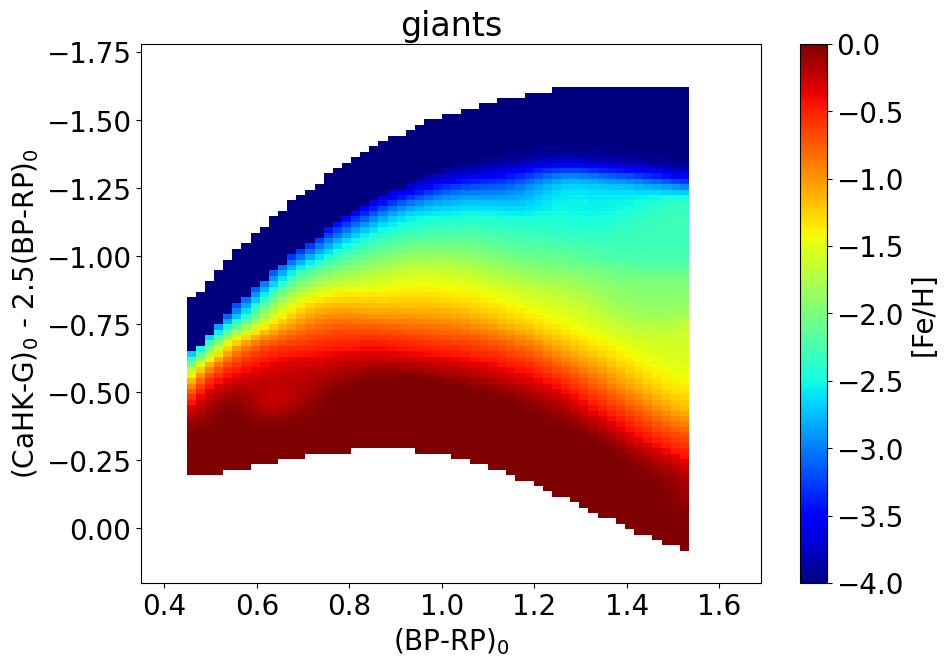

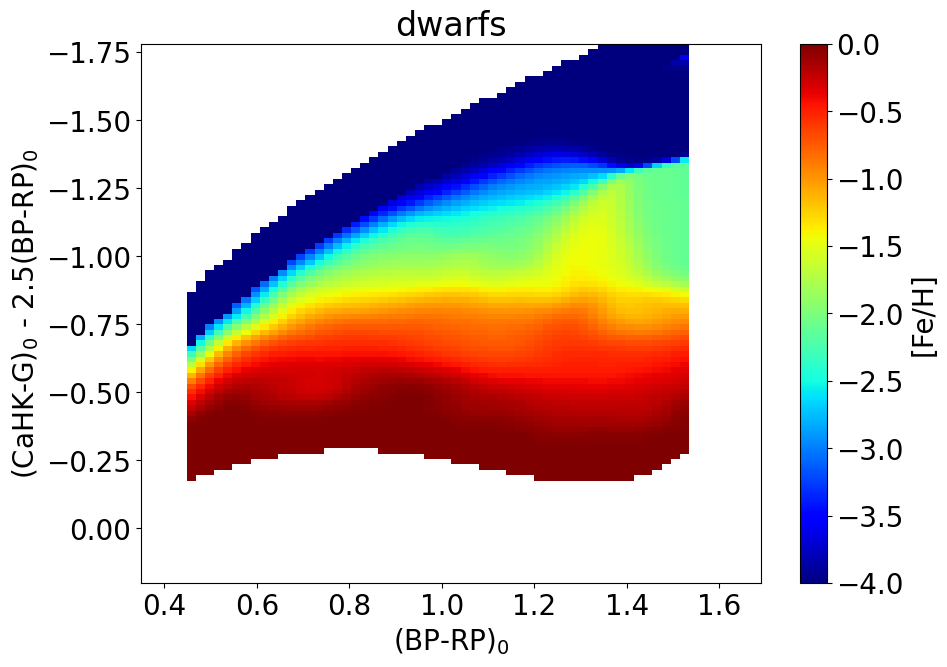

In [87]:
## --------------------------
## Plot the resulting grid
## --------------------------

## Set limits for the colour bar
maxc = 0.0
minc = -4.0

for sub, dati in zip(['giants','dwarfs'],[[data_gi_giants, X_giants, Y_giants],[data_gi_dwarfs, X_dwarfs, Y_dwarfs]]):
    
    data_gi, X, Y = dati
    
    fig = figure(figsize= (10,7))
    frame = fig.add_subplot(1,1,1)

    fehplot_gi = data_gi["FeH"].reshape((len(X), len(Y))).T  #final grid

    ## Plot
    image = frame.imshow(fehplot_gi,cmap='jet', interpolation='none', origin = 'lower', 
                         extent=[X[0]-step/2,X[-1]-step/2,Y[0]+step/2,Y[-1]+step/2], 
                        vmin = minc, vmax=maxc, aspect='auto')  
    fig.colorbar(image, label='[Fe/H]')

    xxs = np.arange(0.4, 1.6, 0.01)

    if (sub == 'all') | (sub == 'dwarfs'):
        ybb_gi = 0.346945 - 3.19276*xxs + 1.85539*xxs**2 - 0.519518*xxs**3 - (bf-2.7)*xxs
        y3_gi = 0.613234 - 4.18968*xxs + 3.01172*xxs**2 - 0.813665*xxs**3 - (bf-2.7)*xxs
    elif sub == 'giants':
        ybb_gi = 0.587261 - 3.70764*xxs + 1.92016*xxs**2 - 0.323654*xxs**3 - (bf-2.7)*xxs
        y3_gi = 0.836432 - 4.55978*xxs + 2.84748*xxs**2 - 0.549882*xxs**3 - (bf-2.7)*xxs
    
    ppar = np.loadtxt('{}polypar_0.0_{}BPRP_{}.txt'.format(polyfol, round(bf,1),sub))
    pol = np.poly1d(ppar)
    
    cmap = matplotlib.cm.get_cmap('jet')
    m3 = cmap(-(-3.0 - minc)/(minc + maxc))

#     plt.plot(xxs, y3_gi, color=m3, linewidth=1.5)
#     plt.plot(xxs, ybb_gi, color='black', linewidth=1.5)

#     plt.plot(xxs, pol(xxs)+0.1, color='magenta', ls='--', lw=1.5)

    ## Set axes
    plt.xlabel('(BP-RP)$_0$')
    plt.ylabel('(CaHK-G)$_0$ - {}(BP-RP)$_0$'.format(round(bf,1)))
    plt.title(sub)
    
    plt.savefig('figures/reference-grid_{}.pdf'.format(sub))
    
    plt.show()


# Photometric [Fe/H] for data

## read file and add E(B-V)/A0

In [88]:
## -----------------------------------
## Read data file to get metallicities for and set some parameters
## -----------------------------------

t0 = time.time()

df_dat = vaex.open(datafile)

## rename the CaHK columns
    
if cat == 'CaHKsyn':

    df_dat.rename('CaHK_syn','CaHK')
    df_dat.rename('d_CaHK_syn','d_CaHK')
    
elif cat == 'Pristine':
    
    df_dat.rename('CaHK_Pr','CaHK')
    df_dat.rename('d_CaHK_Pr','d_CaHK')
    

## if the Gaia DR3 column names are in CDS format, rename to original Gaia DR3 names
if 'Plx' in list(df_dat):
    df_dat.rename('RA','RA_CaHK')
    df_dat.rename('Dec','Dec_CaHK')
    df_dat.rename('RAJ2000','ra_epoch2000')
    df_dat.rename('DEJ2000','dec_epoch2000')
    df_dat.rename('Source','source_id')
    df_dat.rename('RAdeg','ra')
    df_dat.rename('e_RAdeg','ra_error')
    df_dat.rename('DEdeg','dec')
    df_dat.rename('e_DEdeg','dec_error')
    df_dat.rename('Plx','parallax')
    df_dat.rename('e_Plx','parallax_error')
    df_dat.rename('RPlx','parallax_over_error')
    df_dat.rename('PM','pm')
    df_dat.rename('pmRA','pmra')
    df_dat.rename('e_pmRA','pmra_error')
    df_dat.rename('pmDE','pmdec')
    df_dat.rename('e_pmDE','pmdec_error')
    df_dat.rename('NgAL','astrometric_n_good_obs_al')
    df_dat.rename('gofAL','astrometric_gof_al')
    df_dat.rename('chi2AL','astrometric_chi2_al')
    df_dat.rename('epsi','astrometric_excess_noise')
    df_dat.rename('sepsi','astrometric_excess_noise_sig')
    df_dat.rename('Solved','astrometric_params_solved')
    df_dat.rename('pscol','pseudocolour')
    df_dat.rename('e_pscol','pseudocolour_error')
    df_dat.rename('Nper','visibility_periods_used')
    # df_dat.rename('RUWE','ruwe')
    df_dat.rename('Dup','duplicated_source')
    df_dat.rename('FG','phot_g_mean_flux')
    df_dat.rename('e_FG','phot_g_mean_flux_error')
    df_dat.rename('Gmag','phot_g_mean_mag')
    df_dat.rename('FBP','phot_bp_mean_flux')
    df_dat.rename('e_FBP','phot_bp_mean_flux_error')
    df_dat.rename('BPmag','phot_bp_mean_mag')
    df_dat.rename('FRP','phot_rp_mean_flux')
    df_dat.rename('RPmag','phot_rp_mean_mag')
    df_dat.rename('E(BP/RP)','phot_bp_rp_excess_factor')
    df_dat.rename('BP-RP','bp_rp')
    df_dat.rename('e_Gmag','phot_g_mean_mag_error')
    df_dat.rename('e_BPmag','phot_bp_mean_mag_error')
    df_dat.rename('e_RPmag','phot_rp_mean_mag_error')
    # df_dat.rename('e_RAJ2000','ra_epoch2000_error')
    # df_dat.rename('e_DEJ2000','dec_epoch2000_error')
    df_dat.rename('o_Gmag','phot_g_n_obs')
    df_dat.rename('RFG','phot_g_mean_flux_over_error')
    df_dat.rename('o_BPmag','phot_bp_n_obs')
    df_dat.rename('RFBP','phot_bp_mean_flux_over_error')
    df_dat.rename('o_RPmag','phot_rp_n_obs')
    df_dat.rename('e_FRP','phot_rp_mean_flux_error')
    df_dat.rename('RFRP','phot_rp_mean_flux_over_error')

## hack to avoid a very small number of stars with negative errors in the Pristine Gaia synthetic catalogue
df_dat.rename('d_CaHK', 'd_CaHKorig')
df_dat['d_CaHK'] = df_dat.func.where(df_dat.d_CaHKorig < 0, 99.9, df_dat.d_CaHKorig)
    
    
print('time to read file: {}s'.format(round(time.time() - t0,3)))
print('number of stars: {}'.format(len(df_dat)))

## -------------------------
### GET EXTINCTION COLUMN
## -------------------------
t1 = time.time()

## get extinction from dustmaps if necessary
if getext_data == True:

    coords = SkyCoord(df_dat.ra.values*u.deg, df_dat.dec.values*u.deg, frame='icrs', distance=8*u.kpc)
    
    if getext_type_science == 'bay':
        ebv_bay_data = bayestar(coords, mode='mean')
        df_dat["ebv"] = ebv_bay_data
    elif getext_type_science == 'sfd':
        ebv_sfd_data = sfd(coords)
        df_dat["ebv"] = ebv_sfd_data
    elif getext_type_science == 'tge':
        ### need the 0.7 fudge factor to match with our extinction polynomial... for some reason
        a0_tge = tge(coords)
        df_dat["a0"] = a0_tge*0.7
        df_dat["ebv"] = a0_tge/(RV_law/0.95)       ## (A0 is not the same as AV, hence the factor 0.95)

else:
    # or otherwise use a pre-existing extinction column in the input table
    df_dat["ebv"] = df_dat[extcol]


print('time to get extinction: {}s'.format(round(time.time() - t1,3)))

time to read file: 0.697s
number of stars: 766638
time to get extinction: 0.986s


## Extinction

In [89]:
def Teff_casagrande_marginalised(X, feh):
    ## Function to derive photometric temperatures, following the IRFM by Casagrande et al. (2021)
    ## where X = (BP-RP)_0
    
    factor_logg = 3 # marginalise over logg by fixing it to a "middle value"
    
    a0, a1, a2, a3, a4, a5 = 7928, -3663.11, 803.3, -9.37, 0, 325.13
    a6, a7, a8, a9, a10 = -500.11, 279.48, -53.51, 0, -2.42
    a11, a12, a13, a14 = -128.03, 49.49, 5.91, 41.37
    
    teff_cas = a0 + a1*X + a2*X**2 + a3*X**3 + a4*X**5 + a5*factor_logg + a6*factor_logg*X + a7*factor_logg*X**2 +\
        a8*factor_logg*X**3 + a9*factor_logg*X**5 + a10*feh + a11*feh*X + a12*feh*X**2 + a13*feh*X**3 + a14*feh*factor_logg*X
    
    ## stay within validity of Casagrande relation
    teff_cas[teff_cas < 3500] = 3500
    teff_cas[teff_cas > 9000] = 9000
     
    return teff_cas


def metallicity_interp(Xn,Yn, sb):
    ## Function to assign a photoetric metallicity by interpolating in the reference grid
    
    Ndata_n = len(Xn)
    XYgrid_new = np.ones((Ndata_n,2))
    XYgrid_new[:,0] = Xn
    XYgrid_new[:,1] = Yn

    interp_FeH_gi = interpolate.griddata(XYgrid, data_gi["FeH"], XYgrid_new, method='linear')
    
    ## Gaia iso-metallicity line for zero metallicity used to limit the extrapolation (same as in the grid)
    if (sb == 'all') | (sb == 'dwarfs'):
        ybb_gi = 0.346945 - 3.19276*(XYgrid_new[:,0]) + 1.85539*(XYgrid_new[:,0])**2 - 0.519518*(XYgrid_new[:,0])**3  - (bf-2.7)*XYgrid_new[:,0]
    elif sb == 'giants':
        ybb_gi = 0.587261 - 3.70764*(XYgrid_new[:,0]) + 1.92016*(XYgrid_new[:,0])**2 - 0.323654*(XYgrid_new[:,0])**3 - (bf-2.7)*XYgrid_new[:,0]
        
    
    ## for the region above the training grid limits assign [Fe/H] = -4.0
    interp_FeH_gi[ np.isnan(interp_FeH_gi) 
                  & (XYgrid_new[:,0] <= maxx+step) 
                  & (XYgrid_new[:,0] >= minx-step) 
                  & (XYgrid_new[:,1] < ybb_gi - 0.1)
                 ] = -4.0  
    
    ## for the region to the right of the training grid limits, choose [Fe/H] = -2.0 for the giants case (relevant for how extinction is dealt with)
    if (sb == 'giants'):
        interp_FeH_gi[ (XYgrid_new[:,1] < -0.5) & (interp_FeH_gi != -4.0) & (XYgrid_new[:,0] >= maxx-step/2)] = -2.0 
    
    ## for the rest outside the grid or with nan adopt solar metallicity (relevant for how extinction is dealt with)
    interp_FeH_gi = np.nan_to_num(interp_FeH_gi, nan = 0.0)
    
    return interp_FeH_gi

In [90]:
## For giants and dwarfs separately

for sub, lab, dati in zip(['giants', 'dwarfs'],['','_dw'],[[data_gi_giants, X_giants, Y_giants],[data_gi_dwarfs, X_dwarfs, Y_dwarfs]]):
    
    ## populate the grid
    data_gi, X, Y = dati
    
    t2 = time.time()

    ## depending on the extinction map, get a first estimate of A0 or EBV
    if (getext_type_science == 'sfd'):
        EBVval = df_dat['ebv'].to_numpy()
        RV = RV_law
        A0val = RV * EBVval * sfdfac
    elif (getext_type_science == 'bay'):
        EBVval = df_dat['ebv'].to_numpy()
        RV = RV_law
        A0val = RV * EBVval * sfdfac
    elif (getext_type_science == 'tge'):
        RV = RV_law
        A0val = df_dat['a0'].to_numpy()
        EBVval = A0val/(RV/0.95)

    ## get the appropriate extinction polynomial parameters to use
    if sub == 'giants':
        model_g = fit_parameters_giant[0]
        model_bp = fit_parameters_giant[1]
        model_rp = fit_parameters_giant[2] 
        model_cahk = fit_parameters_giant[3] 
        model_a0av = fit_parameters_giant[4] 
    elif sub == 'dwarfs':
        model_g = fit_parameters_dwarf[0]
        model_bp = fit_parameters_dwarf[1]
        model_rp = fit_parameters_dwarf[2]  
        model_cahk = fit_parameters_dwarf[3] 
        model_a0av = fit_parameters_dwarf[4] 
        
    ## Create numpy arrays for the original magnitudes
    CaHK_orig = df_dat.CaHK.to_numpy()
    G_orig = df_dat.phot_g_mean_mag.to_numpy() 
    BP_orig = df_dat.phot_bp_mean_mag.to_numpy()
    RP_orig = df_dat.phot_rp_mean_mag.to_numpy()

    ## First estimates of the extinction correction (based on educated guesses)
    BP_RP_guess_corr = BP_orig - RP_orig - EBVval
    G_guess_corr = G_orig - 2.0*EBVval 
    CaHK_guess_corr = CaHK_orig - 4.0*EBVval 

    ## Iteratively derive photometric Teff and [Fe/H] to derive dereddened colours
    i = 0
    while i<5:
        # default = 5

        print('extinction iteration ({}): {}'.format(sub, i+1))

        ## compute photometric metallicity and photometric temperature estimates
        phot_metal_corr = metallicity_interp(BP_RP_guess_corr,(CaHK_guess_corr-G_guess_corr)-bf*(BP_RP_guess_corr), sub)
        Teff_corr = Teff_casagrande_marginalised(BP_RP_guess_corr, phot_metal_corr) 

        if (getext_type_science == 'bay') | (getext_type_science == 'sfd'):
            ## conversion factor beteen A0 and AV depends on Teff and [FeH] (and A_0 itself):
            A0AV_guess = polynomial_model((Teff_corr/5040, A0val, phot_metal_corr), *model_a0av)
            ## convert E(B-V) to A_0, including the SFD rescaling factor
            A0val = RV * A0AV_guess * EBVval * sfdfac

        ## derive extinction coefficients for each filter, as function of Teff, A_0 and [Fe/H]
        kg_gaia = polynomial_model((Teff_corr/5040, A0val, phot_metal_corr), *model_g)
        kbp_gaia = polynomial_model((Teff_corr/5040, A0val, phot_metal_corr), *model_bp)
        krp_gaia = polynomial_model((Teff_corr/5040, A0val, phot_metal_corr), *model_rp)
        kcahk = polynomial_model((Teff_corr/5040, A0val, phot_metal_corr), *model_cahk)

        ## update guesses for the dereddened photometry
        G_guess_corr = G_orig - kg_gaia*A0val
        BP_guess_corr = BP_orig - kbp_gaia*A0val
        RP_guess_corr = RP_orig - krp_gaia*A0val
        CaHK_guess_corr = CaHK_orig - kcahk*A0val

        BP_RP_guess_corr = BP_guess_corr - RP_guess_corr

        i+= 1

    ## add dereddened photometry and first photometric metallicity guess to the table
    df_dat["G_0{}".format(lab)] = G_guess_corr
    df_dat["BP_0{}".format(lab)] = BP_guess_corr
    df_dat["RP_0{}".format(lab)] = RP_guess_corr
    df_dat["CaHK_0{}".format(lab)] = CaHK_guess_corr
    df_dat["fehguess{}".format(lab)] = phot_metal_corr

    print('time for extinction correction {}: {}s'.format(sub, round(time.time() - t2,3)))


extinction iteration (giants): 1
extinction iteration (giants): 2
extinction iteration (giants): 3
extinction iteration (giants): 4
extinction iteration (giants): 5


/var/folders/zt/72sc1rfn597b07rg__8wltd40000gp/T/ipykernel_96308/734948741.py:35: RuntimeWarning: overflow encountered in power
  ybb_gi = 0.587261 - 3.70764*(XYgrid_new[:,0]) + 1.92016*(XYgrid_new[:,0])**2 - 0.323654*(XYgrid_new[:,0])**3 - (bf-2.7)*XYgrid_new[:,0]
/var/folders/zt/72sc1rfn597b07rg__8wltd40000gp/T/ipykernel_96308/734948741.py:11: RuntimeWarning: overflow encountered in power
  teff_cas = a0 + a1*X + a2*X**2 + a3*X**3 + a4*X**5 + a5*factor_logg + a6*factor_logg*X + a7*factor_logg*X**2 +\
/var/folders/zt/72sc1rfn597b07rg__8wltd40000gp/T/ipykernel_96308/734948741.py:11: RuntimeWarning: invalid value encountered in multiply
  teff_cas = a0 + a1*X + a2*X**2 + a3*X**3 + a4*X**5 + a5*factor_logg + a6*factor_logg*X + a7*factor_logg*X**2 +\
/var/folders/zt/72sc1rfn597b07rg__8wltd40000gp/T/ipykernel_96308/734948741.py:12: RuntimeWarning: overflow encountered in power
  a8*factor_logg*X**3 + a9*factor_logg*X**5 + a10*feh + a11*feh*X + a12*feh*X**2 + a13*feh*X**3 + a14*feh*factor_l

time for extinction correction giants: 4.118s
extinction iteration (dwarfs): 1
extinction iteration (dwarfs): 2
extinction iteration (dwarfs): 3
extinction iteration (dwarfs): 4
extinction iteration (dwarfs): 5


/var/folders/zt/72sc1rfn597b07rg__8wltd40000gp/T/ipykernel_96308/734948741.py:33: RuntimeWarning: overflow encountered in power
  ybb_gi = 0.346945 - 3.19276*(XYgrid_new[:,0]) + 1.85539*(XYgrid_new[:,0])**2 - 0.519518*(XYgrid_new[:,0])**3  - (bf-2.7)*XYgrid_new[:,0]


time for extinction correction dwarfs: 3.959s


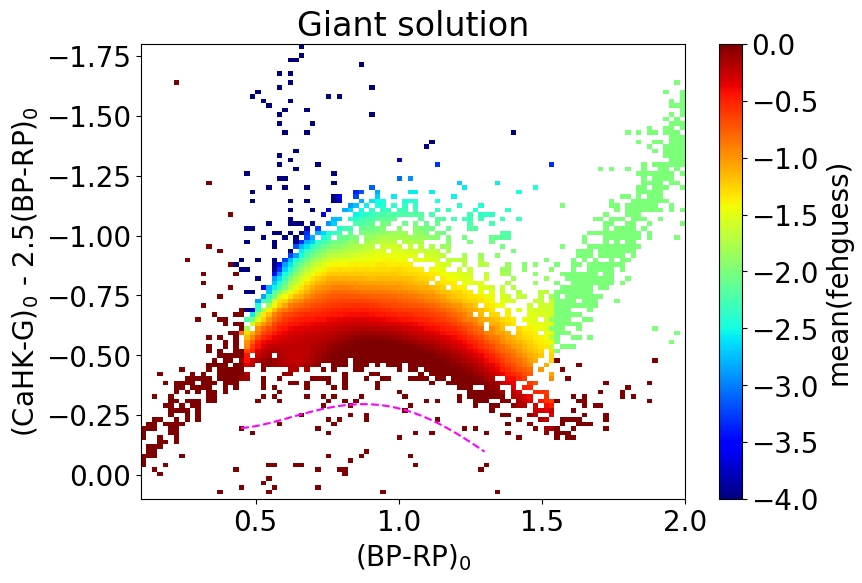

In [91]:
## ----------------------
## OPTIONAL: Check metallicity assumptions in extinction correction (in the giants case)
## ----------------------

if check_metassumptions == True:

    xxs2 = np.arange(0.45, 1.3, 0.01)
    ppar_g = np.loadtxt('{}polypar_0.0_{}BPRP_giants.txt'.format(polyfol, round(bf,1)))
    pol_g = np.poly1d(ppar_g)

    df_dat.viz.heatmap("BP_0 - RP_0","(CaHK_0-G_0-{}*(BP_0-RP_0))".format(bf), what=(vaex.stat.mean("fehguess")),
                                 figsize=(9,6), colormap='jet', limits=[[0.1, 2.0],[0.1, -1.8]], vmin=-4, vmax=0,
                                xlabel='(BP-RP)$_0$', ylabel='(CaHK-G)$_0$ - {}(BP-RP)$_0$'.format(round(bf,1)), shape=100)


    plt.plot(xxs2, pol_g(xxs2)+0.3, color='magenta', ls='--', lw=1.5)
    plt.title('Giant solution')
    
    plt.savefig('figures/check_extinction-metallicity_assumptions_g_{}.pdf'.format(cat))

    plt.show()


## Compute and add C*

In [92]:
if compute_Cstar == True:
    
    ## Following Equations 6 (+Table 2) and 18 in Riello et al. (2021)

    bprp = df_dat['phot_bp_mean_mag-phot_rp_mean_mag'].to_numpy()
    C = df_dat['phot_bp_rp_excess_factor'].to_numpy()

    Cstar_factor = np.zeros(len(bprp))

    cond = np.where(bprp < 0.5)
    Cstar_factor[cond] = 1.154360 + 0.033772*bprp[cond] + 0.032277*bprp[cond]**2

    cond = np.where((bprp >= 0.5) & (bprp < 4.0))
    Cstar_factor[cond] = 1.162004 + 0.011464*bprp[cond] + 0.049255*bprp[cond]**2 - 0.005879*bprp[cond]**3

    cond = np.where(bprp >= 4.0)
    Cstar_factor[cond] = 1.057572 + 0.140537*bprp[cond]

    df_dat['Cstar'] = C - Cstar_factor   
    df_dat['Cstar_1sigma'] = 0.0059898 + 8.817481e-12 * df_dat.phot_g_mean_mag**(7.618399)
    
else:
    df_dat['Cstar'] = np.nan
    df_dat['Cstar_1sigma'] = np.nan

## Monte carlo samples + interpolation

In [120]:
t_mc1 = time.time()

## for giants and dwarfs separately, do monte carlo sampling to derive uncertainties on the photometric metallicity

resultlist = []
for sub, lab, dati in zip(['giants', 'dwarfs'],['','_dw'],[[data_gi_giants, X_giants, Y_giants],[data_gi_dwarfs, X_dwarfs, Y_dwarfs]]):
    
    data_gi, X, Y = dati
    
    zpd = pd.DataFrame()
    df_dat_metresults = vaex.from_pandas(df=zpd, copy_index=True)

    ## it is split up in chunks to not keep everything in memory at the same time
    chunksize = 500000
    chunks = np.arange(0,len(df_dat),chunksize)

    for ch in np.arange(0,len(chunks)):
        t_00 = time.time()

        if chunks[ch]+chunksize < len(df_dat):
            df_dat_sub = df_dat[chunks[ch]:chunks[ch+1]]
        else:
            df_dat_sub = df_dat[chunks[ch]:]

        ## get length of the data for the monte carlo samples
        Ndata = len(df_dat_sub['CaHK_0{}'.format(lab)].to_numpy())

        t25 = time.time()

        ## Get X (BP-RP) and Y (CaHK-G)-2.5(BP-RP)
        xplot_right_gi = (df_dat_sub['BP_0{}'.format(lab)] - df_dat_sub['RP_0{}'.format(lab)]).to_numpy()
        yplot_right_gi = (df_dat_sub['CaHK_0{}'.format(lab)] - df_dat_sub['G_0{}'.format(lab)]).to_numpy() - bf*xplot_right_gi

        ## get monte carlo samples for X and Y, the number = n_MC (set in the "initial settings" at the start)
        xplot_right_gi_i = np.random.normal(loc=df_dat_sub['BP_0{}'.format(lab)].to_numpy(), 
                                            scale=df_dat_sub['phot_bp_mean_mag_error'].to_numpy(), 
                                            size = (n_MC, Ndata)).T - np.random.normal(loc=df_dat_sub['RP_0{}'.format(lab)].to_numpy(), 
                                                                                       scale=df_dat_sub['phot_rp_mean_mag_error'].to_numpy(), 
                                                                                       size = (n_MC, Ndata)).T
        yplot_right_gi_i = np.random.normal(loc=df_dat_sub['CaHK_0{}'.format(lab)].to_numpy(), 
                                            scale=df_dat_sub['d_CaHK'].to_numpy(), 
                                            size = (n_MC, Ndata)).T - np.random.normal(loc=df_dat_sub['G_0{}'.format(lab)].to_numpy(), 
                                                                                       scale=df_dat_sub['phot_g_mean_mag_error'].to_numpy(), 
                                                                                       size = (n_MC, Ndata)).T -bf*xplot_right_gi_i

        XYgrid_new = np.ones((Ndata*n_MC,2))
        XYgrid_new[:,0] = xplot_right_gi_i.flatten()
        XYgrid_new[:,1] = yplot_right_gi_i.flatten()

        ## --------------------------
        ## Do the interpolation 
        ## --------------------------

        t3 = time.time()

        ## interpolate data onto reference grid
        interp_FeH_gi_i = np.ones(len(xplot_right_gi_i))*np.nan
        interp_FeH_gi_i = interpolate.griddata(XYgrid, data_gi["FeH"], XYgrid_new, method='linear')

        interp_FeH_gi_alli = interp_FeH_gi_i.reshape(Ndata, n_MC)

        t4 = time.time()

        n_notnan = sum(~np.isnan(interp_FeH_gi_alli.T))
        df_dat_sub['mcfrac_{}{}'.format(cat,lab)] = n_notnan/n_MC

        ## Get median, 16th and 84 percentiles from the MC samples
        interp_FeH_gi = np.nanpercentile(interp_FeH_gi_alli, 50, axis = 1)
        interp_FeH_gi_p16 = np.nanpercentile(interp_FeH_gi_alli, 16, axis = 1)
        interp_FeH_gi_p84 = np.nanpercentile(interp_FeH_gi_alli, 84, axis = 1)

        # add derived values to dictionary
        df_dat_sub['FeH_{}{}_50th'.format(cat,lab)] = interp_FeH_gi
        df_dat_sub['FeH_{}{}_16th'.format(cat,lab)] = interp_FeH_gi_p16
        df_dat_sub['FeH_{}{}_84th'.format(cat,lab)] = interp_FeH_gi_p84

        ## --------------------------
        ## add to general results dataframe
        ## --------------------------
        
        cols_i = ['source_id','ra','dec','ebv','Pvar', 'RUWE', 'Cstar','Cstar_1sigma', 'd_CaHK',
                  'phot_g_mean_mag_error', 'phot_bp_mean_mag_error', 'phot_rp_mean_mag_error','phot_g_mean_mag',
                                            'G_0{}'.format(lab),'BP_0{}'.format(lab),
                                            'RP_0{}'.format(lab),'CaHK_0{}'.format(lab),
                                            'FeH_{}{}_50th'.format(cat,lab),'FeH_{}{}_16th'.format(cat,lab),
                                            'FeH_{}{}_84th'.format(cat,lab),'mcfrac_{}{}'.format(cat,lab)]
        
        ## for the real Pristine CaHK there is a merged_CASU_flag
        if cat == "Pristine":
            cols_i.append('merged_CASU_flag')
            
        df_dat_sub_metresults = df_dat_sub[cols_i]
        
        df_dat_metresults = df_dat_metresults.concat(df_dat_sub_metresults)

        print('({}) time to do chunk {}/{}: {}s'.format(sub, ch+1, len(chunks), round(time.time()-t_00)))

    ## ----------------
    ## include "direct" metallicity value instead of median from draws

    Ndata_mid = len(df_dat_metresults['CaHK_0{}'.format(lab)].to_numpy())

    xplot_right_mid = (df_dat_metresults['BP_0{}'.format(lab)] - df_dat_metresults['RP_0{}'.format(lab)]).to_numpy()
    yplot_right_mid = (df_dat_metresults['CaHK_0{}'.format(lab)] - df_dat_metresults['G_0{}'.format(lab)]).to_numpy() - bf*xplot_right_mid

    XYgrid_new_mid = np.ones((Ndata_mid,2))
    XYgrid_new_mid[:,0] = xplot_right_mid
    XYgrid_new_mid[:,1] = yplot_right_mid

    ## interpolate data onto reference grid
    interp_FeH_gi_mid = np.ones(len(xplot_right_gi))*np.nan
    interp_FeH_gi_mid = interpolate.griddata(XYgrid, data_gi["FeH"], XYgrid_new_mid, method='linear')

    df_dat_metresults['FeH_{}{}'.format(cat,lab)] = interp_FeH_gi_mid
    
    resultlist.append(df_dat_metresults)

    ## ----------------
    
print('total time for the MC: {}s'.format(round(time.time() - t_mc1)))

    
#### COMBINE GIANTS & DWARFS SOLUTIONS

df_dat_metresults_both = resultlist[0].join(resultlist[1],  rsuffix='_r')

cols = ['source_id','ra','dec','ebv','Pvar', 'RUWE', 'Cstar','Cstar_1sigma', 'd_CaHK','phot_g_mean_mag',
       'phot_g_mean_mag_error' ,'phot_bp_mean_mag_error', 'phot_rp_mean_mag_error']
for lab in ['', '_dw']:
    cols.extend(['G_0{}'.format(lab),'BP_0{}'.format(lab),
                        'RP_0{}'.format(lab),'CaHK_0{}'.format(lab), 'FeH_{}{}'.format(cat,lab),
                        'FeH_{}{}_50th'.format(cat,lab),'FeH_{}{}_16th'.format(cat,lab),
                        'FeH_{}{}_84th'.format(cat,lab),'mcfrac_{}{}'.format(cat,lab)])
    
if cat == "Pristine":
        cols.append('merged_CASU_flag')

df_dat_metresults_both = df_dat_metresults_both[cols]

# #### EXPORT

t_s = time.time()

df_dat_metresults_both.export(allout) 

print('time to save to file: {}s'.format(round(time.time()-t_s)))

/Users/ankearentsen/miniforge3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


(giants) time to do chunk 1/2: 14s
(giants) time to do chunk 2/2: 7s
(dwarfs) time to do chunk 1/2: 14s
(dwarfs) time to do chunk 2/2: 7s
total time for the MC: 43s
time to save to file: 12s


# Plot results

In [102]:
# ## Either load it directly from the file:
# plotdf = vaex.open(allout)

# Or just take the dataframe from above if it's still active:
plotdf = df_dat_metresults_both

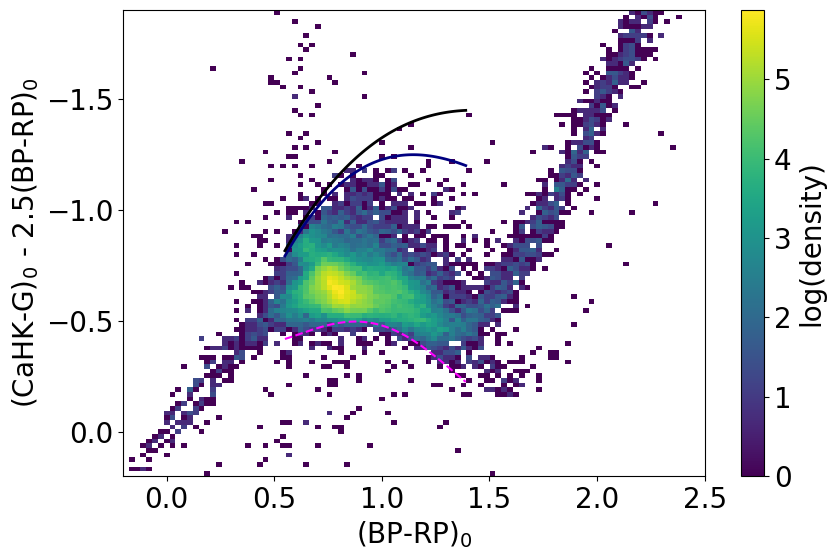

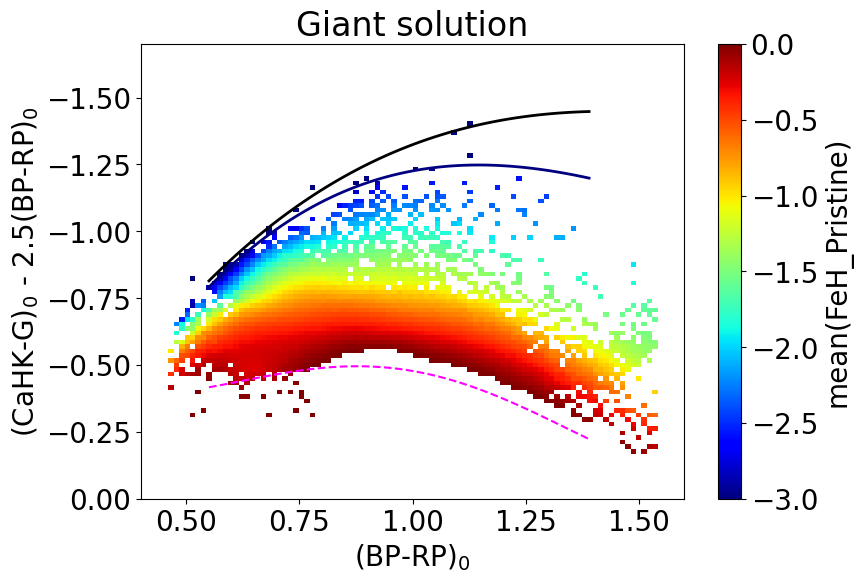

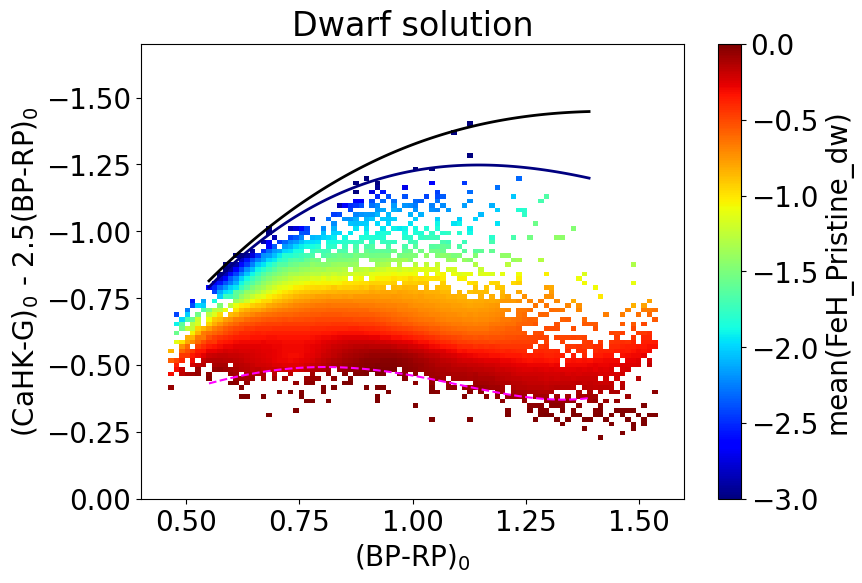

In [103]:
##################### Iso-metallicity lines

bf = 2.5

xxs2 = np.arange(0.55, 1.4, 0.01)

## Dwarf BB and -3.0 lines
ybb_gi2_dw = 0.346945 - 3.19276*xxs2 + 1.85539*xxs2**2 - 0.519518*xxs2**3 - (bf-2.7)*xxs2
y3_gi2_dw = 0.613234 - 4.18968*xxs2 + 3.01172*xxs2**2 - 0.813665*xxs2**3 - (bf-2.7)*xxs2

## Giants BB and -3.0 lines
ybb_gi2_g = 0.587261 - 3.70764*xxs2 + 1.92016*xxs2**2 - 0.323654*xxs2**3 - (bf-2.7)*xxs2
y3_gi2_g = 0.836432 - 4.55978*xxs2 + 2.84748*xxs2**2 - 0.549882*xxs2**3 - (bf-2.7)*xxs2

## Dwarf solar metallicity line
ppar_d = np.loadtxt('{}polypar_0.0_{}BPRP_dwarfs.txt'.format(polyfol, round(bf,1)))
pol_d = np.poly1d(ppar_d)

## Giants solar metallicity line
ppar_g = np.loadtxt('{}polypar_0.0_{}BPRP_giants.txt'.format(polyfol, round(bf,1)))
pol_g = np.poly1d(ppar_g)
    
## Plot settings for the colour bar
cmap = matplotlib.cm.get_cmap('jet')
maxc = -0.5
minc = -3.0
m3 = cmap(-(-3.0 - minc)/(minc + maxc))


# ##################### Plot the density of all the stars in the CCD

plotdf.viz.heatmap("BP_0 - RP_0","(CaHK_0-G_0-{}*(BP_0-RP_0))".format(bf),
                             figsize=(9,6), colormap='viridis', limits=[[-0.2, 2.5],[0.2, -1.9]], 
                            xlabel='(BP-RP)$_0$', ylabel='(CaHK-G)$_0$ - {}(BP-RP)$_0$'.format(round(bf,1)),
                             colorbar_label='log(density)', shape=100,f="log",)

plt.plot(xxs2, y3_gi2_g, color=m3, linewidth=2)
plt.plot(xxs2, ybb_gi2_g, color='black', lw=2)
plt.plot(xxs2, pol_g(xxs2)+0.1, color='magenta', ls='--', lw=1.5)

plt.savefig('figures/CCD_density_{}.pdf'.format(samp))

plt.show()


## CCD: Giant metallicities after quality cuts
plotdf[
         (plotdf["FeH_{}".format(cat)] < 0) 
       & (plotdf["FeH_{}".format(cat)] > -4)
       & (plotdf["mcfrac_{}".format(cat)] > 0.8) 
       & ((plotdf["FeH_{}_84th".format(cat)] - plotdf["FeH_{}_16th".format(cat)])/2 < 0.5)
       & (plotdf.Pvar < 0.3) 
       & (plotdf.RUWE < 1.4)
       & (plotdf.Cstar < plotdf.Cstar_1sigma)
      ].viz.heatmap("BP_0 - RP_0","(CaHK_0-G_0-{}*(BP_0-RP_0))".format(bf),
                             what=(vaex.stat.mean("FeH_{}".format(cat))),
                              figsize=(9,6), colormap='jet', limits=[[0.4, 1.6],[0.0, -1.7]],
                            xlabel='(BP-RP)$_0$', ylabel='(CaHK-G)$_0$ - {}(BP-RP)$_0$'.format(round(bf,1)),
                             shape=100, vmin=-3, vmax=0)

plt.plot(xxs2, y3_gi2_g, color=m3, linewidth=2)
plt.plot(xxs2, ybb_gi2_g, color='black', linewidth=2)
plt.plot(xxs2, pol_g(xxs2)+0.1, color='magenta', ls='--', lw=1.5)
plt.title('Giant solution')
plt.savefig('figures/CCD_FeHgiant_{}.pdf'.format(samp))


plt.show()

## CCD: Dwarf metallicities after quality cuts
plotdf[
         (plotdf["FeH_{}_dw".format(cat)] < 0) 
       & (plotdf["FeH_{}_dw".format(cat)] > -4)
       & (plotdf["mcfrac_{}_dw".format(cat)] > 0.8) 
       & ((plotdf["FeH_{}_dw_84th".format(cat)] - plotdf["FeH_{}_dw_16th".format(cat)])/2 < 0.5)
       & (plotdf.Pvar < 0.3) 
       & (plotdf.RUWE < 1.4)
       & (plotdf.Cstar < plotdf.Cstar_1sigma)
      ].viz.heatmap("BP_0 - RP_0","(CaHK_0-G_0-{}*(BP_0-RP_0))".format(bf),
                             what=(vaex.stat.mean("FeH_{}_dw".format(cat))), colormap='jet', vmin=-3, vmax=0,
                              figsize=(9,6),  limits=[[0.4, 1.6],[0.0, -1.7]],
                            xlabel='(BP-RP)$_0$', ylabel='(CaHK-G)$_0$ - {}(BP-RP)$_0$'.format(round(bf,1)),
                             shape=100)

plt.plot(xxs2, y3_gi2_g, color=m3, linewidth=2)
plt.plot(xxs2, ybb_gi2_g, color='black', linewidth=2)
plt.plot(xxs2, pol_d(xxs2)+0.1, color='magenta', ls='--', lw=1.5)
plt.title('Dwarf solution')
plt.savefig('figures/CCD_FeHdwarf_{}.pdf'.format(samp))

plt.show()


# Plot Pristine-CaHKsyn comparison

Can only be run after running the above code for both Pristine & CaHKsyn

In [121]:
Pri = vaex.open('photmet_out/results_CaHK_Pristine_subset_g+dw.csv')
syn = vaex.open('photmet_out/results_CaHK_CaHKsyn_subset_g+dw.csv')

In [122]:
both = Pri.join(syn, how='left', left_on ='source_id', right_on='source_id', allow_duplication=True, lsuffix='_syn')

In [123]:
catQ = 'Pristine'
highQ = both[
         (both["FeH_{}".format(catQ)] < 0) 
       & (both["FeH_{}".format(catQ)] > -4)
       & (both["mcfrac_{}".format(catQ)] > 0.8) 
       & ((both["FeH_{}_84th".format(catQ)] - both["FeH_{}_16th".format(catQ)])/2 < 0.5)
       & (both.Pvar < 0.3) 
       & (both.RUWE < 1.4)
       & (both.Cstar < both.Cstar_1sigma)
      ]

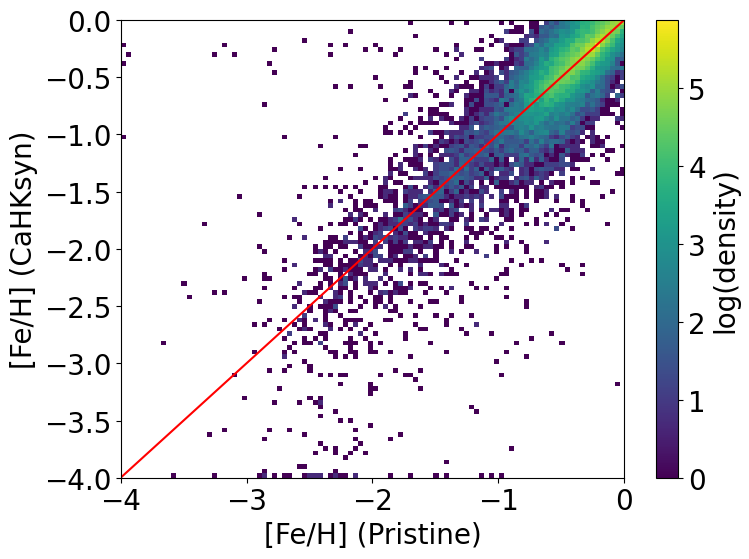

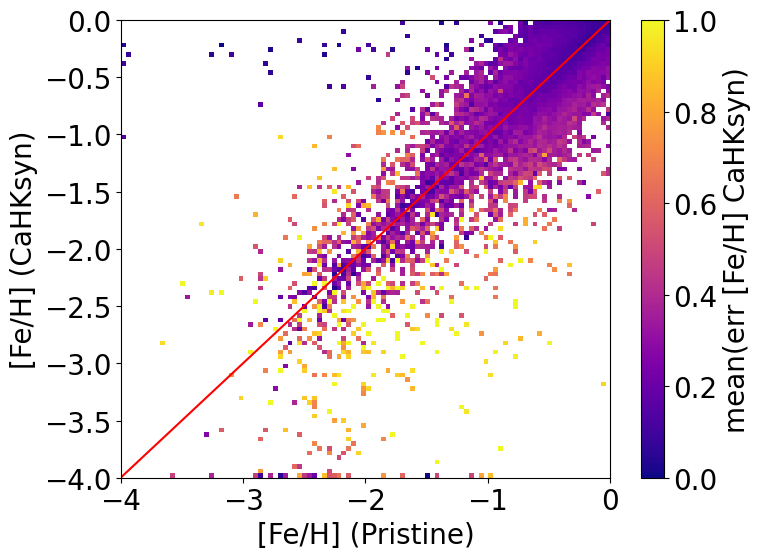

In [135]:
highQ.viz.heatmap("FeH_Pristine","FeH_CaHKsyn",
                             figsize=(8,6), colormap='viridis', limits=[[-4.0,0],[-4.0,0]], 
                            xlabel='[Fe/H] (Pristine)', ylabel='[Fe/H] (CaHKsyn)',
                             colorbar_label='log(density)', shape=100,f="log",)

plt.plot([-4,0],[-4,0], color='red')

plt.savefig('figures/compare_FeHPristine-FeHCaHKsyn_density.pdf')
plt.show()

highQ.viz.heatmap("FeH_Pristine","FeH_CaHKsyn",
                              what=(vaex.stat.mean("(FeH_CaHKsyn_84th - FeH_CaHKsyn_16th)/2")), colormap='plasma', vmin=0, vmax=1.0,
                             figsize=(8,6), limits=[[-4.0,0],[-4.0,0]], 
                            xlabel='[Fe/H] (Pristine)', ylabel='[Fe/H] (CaHKsyn)',
                             colorbar_label='mean(err [Fe/H] CaHKsyn)', shape=100)

plt.plot([-4,0],[-4,0], color='red')

plt.savefig('figures/compare_FeHPristine-FeHCaHKsyn_errFeHCaHKsyn.pdf')
plt.show()